### Project 3: Eyes Classification

#### Project by: Kishan Patel (200527734)
________________________________________________________________________

#### Importing the required libraries.

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import layers
! pip install visualkeras
import visualkeras
import os

import warnings
warnings.filterwarnings('ignore')

#### Loading the dataset images

In [222]:
folder_name = 'Images'
image_label = []
image_path = []

# Iterate through all files in the directory and its subdirectories
for dirpath, _,filenames in os.walk(folder_name):
    for filename in filenames:
        
        # Extract the label from the current directory name
        label = os.path.split(dirpath)[1]
        image_label.append(label)
        
         # Construct the full path to the image file
        full_path = os.path.join(dirpath, filename)
        image_path.append(full_path)
       
# Create a DataFrame to store the image paths and labels
eyes = pd.DataFrame(columns=['ImageFile','Class'])
eyes['ImageFile']=image_path
eyes['Class']=image_label

# Shuffle the DataFrame rows
eyes = eyes.sample(frac=1).reset_index(drop=True)

### EDA and Visualisation

In [223]:
#loading the first 5 rpws
eyes.head()

,ImageFile,Class
0,Images\femaleeyes\4819.jpg,femaleeyes
1,Images\femaleeyes\2941.jpg,femaleeyes
2,Images\maleeyes\1734.jpg,maleeyes
3,Images\maleeyes\6219.jpg,maleeyes
4,Images\maleeyes\3594.jpg,maleeyes


In [224]:
#Checking the number of images combined
len(eyes)

11525

Our Dataframe contains 11525 total images.

In [225]:
eyes.describe()

,ImageFile,Class
count,11525,11525
unique,11525,2
top,Images\femaleeyes\4819.jpg,maleeyes
freq,1,6323


It is obvious that we have made the dataframe by inputing images data by ourselves so there will be no null values in the dataframe. But let's check if we encounter duplicates.

In [114]:
eyes.duplicated().any()

False

We can see that our dataframe contains 0 duplicate entries

maleeyes      6323
femaleeyes    5202
Name: Class, dtype: int64


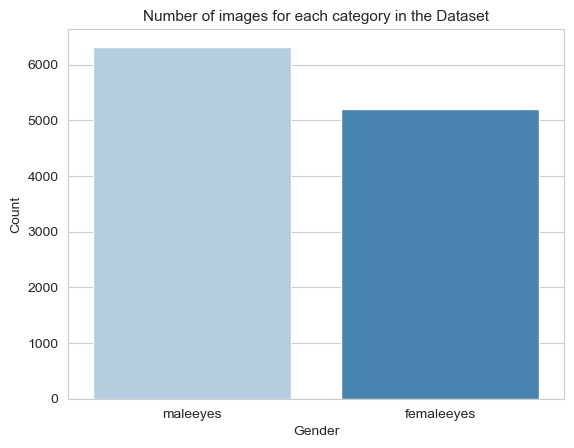

In [228]:
# Count number of samples for each category [Male, Female]
labelCount = eyes['Class'].value_counts()
print(labelCount)

# Plot the counts as a bar chart
sns.set_style("whitegrid")
sns.barplot(x=labelCount.index, y=labelCount, palette='Blues')
plt.title("Number of images for each category in the Dataset", fontsize=11)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

We can see that the dataframe has 6323 male eyes sample whereas it has 5202 female eyes sample. It seems like we have been given less images of female eyes, so we would downsample the men eyes just to balance the dataset so that it does not create problem while training the ML model.

In [229]:
# Using downsampling to balance the dataset, 
# as there is not a big difference in the total number of samples in both categories

# Dividing majority and minority classes
male_eyes = eyes[eyes.Class=='maleeyes']
female_eyes = eyes[eyes.Class=='femaleeyes']

# Downsample the majority class
male_eyes_downsampled = resample(male_eyes,
               replace=False,  # Down sample without replacement
               n_samples=5202,   # Number to match minority class
               random_state=42)
  
# Combine the downsampled majority class and minority class
eyes = pd.concat([male_eyes_downsampled, female_eyes])

# Shuffle the data
eyes = shuffle(eyes)

# Reset the index of the DataFrame
eyes = eyes.reset_index(drop=True)

# Display count of data points in both class
print(eyes.Class.value_counts())

femaleeyes    5202
maleeyes      5202
Name: Class, dtype: int64


,ImageFile,Class
count,10404,10404
unique,10404,2
top,Images\femaleeyes\6229.jpg,femaleeyes
freq,1,5202


Now that we have downsampled the male eyes images, we can see the equal number of images of both categories are stored in the dataset.

In [117]:
# Get index of male and female eye
female_index = eyes[eyes['Class'] == 'femaleeyes'].index[0] # index of female eye
male_index = eyes[eyes['Class'] == 'maleeyes'].index[0] # index of male eye

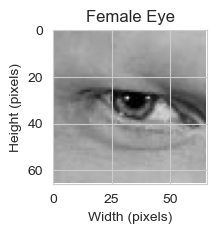

In [243]:
# Load the image of the female eye
female_eye = plt.imread(eyes["ImageFile"][female_index])

# Create a new figure and set its size
fig, ax = plt.subplots(figsize=(2, 2))

# Display the image on the axis
ax.imshow(female_eye)

# Set the axis limits to the dimensions of the image
ax.set_xlim([0, female_eye.shape[1]])
ax.set_ylim([female_eye.shape[0], 0])

# Add a title and axis labels
ax.set_title("Female Eye")
ax.set_xlabel("Width (pixels)")
ax.set_ylabel("Height (pixels)")

# Display the plot
plt.show()

Displayed the single female eye image with height and width in pixels.

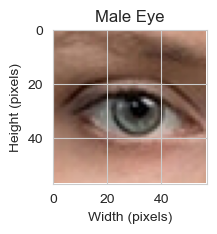

In [244]:
# Load the image of the male eye
male_eye = plt.imread(eyes["ImageFile"][male_index])

# Create a new figure and set its size
fig, ax = plt.subplots(figsize=(2, 2))

# Display the image on the axis
ax.imshow(male_eye)

# Set the axis limits to the dimensions of the image
ax.set_xlim([0, male_eye.shape[1]])
ax.set_ylim([male_eye.shape[0], 0])

# Add a title and axis labels
ax.set_title("Male Eye")
ax.set_xlabel("Width (pixels)")
ax.set_ylabel("Height (pixels)")

# Display the plot
plt.show()

Displayed the single male eye image with height and width in pixels.

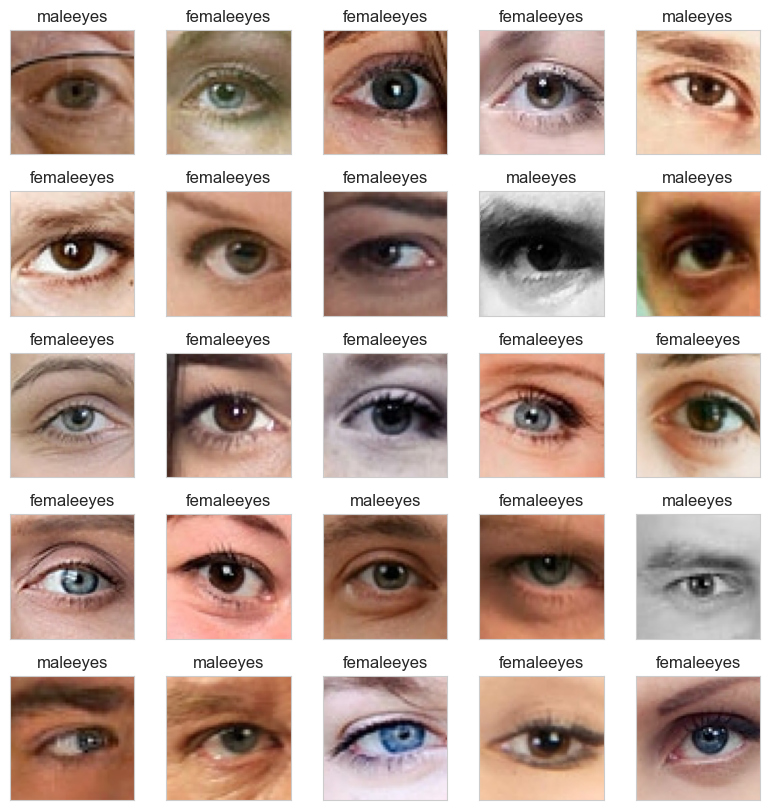

In [245]:
# Get a random sample of 25 images and their labels from the dataset
indices = np.random.choice(len(eyes), 25, replace=False)
images = eyes["ImageFile"].iloc[indices]
labels = eyes["Class"].iloc[indices]

# Create a new figure with a grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10,10))

# Iterate through the subplots and display an image and its label
for i, ax in enumerate(axes.flat):
    # Load the image
    image = plt.imread(images.iloc[i])
    # Display the image on the subplot
    ax.imshow(image)
    # Set the subplot title to the image label
    ax.set_title(labels.iloc[i])
    # Remove the axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3, wspace=0.05)

# Display the plot
plt.show()

In [246]:
# Get the unique sizes of the images in the dataset
unique_sizes = set()
for i in range(len(eyes)):
    image = plt.imread(eyes["ImageFile"][i])
    unique_sizes.add(image.shape)

# Print the number of unique image sizes, smallest size, and largest size
print("Number of different image sizes:", len(unique_sizes))

smallest_size = min(unique_sizes)
largest_size = max(unique_sizes)

print("Smallest image size:", smallest_size)
print("Largest image size:", largest_size)

Number of different image sizes: 64
Smallest image size: (41, 41, 3)
Largest image size: (113, 113, 3)


The dataset contains 64 different size images. (41,41,3) being the smallest size and (113,113,3) being the largest size.

In [247]:
image_size = (64, 64)
eyes_array = eyes.copy()

unique_sizes = set()
for i, image_file in enumerate(eyes['ImageFile']):
    image = cv2.imread(image_file)
    resized_image = cv2.resize(image, image_size)
    rgb_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    unique_sizes.add(rgb_image.shape)
    flattened_image = np.ndarray.flatten(rgb_image)
    eyes_array['ImageFile'][i] = flattened_image

It is important that we give same kind of inputs to the model we are training, therefore we resized the images and now since they are resized, let's check the size.

In [248]:
unique_sizes

{(64, 64, 3)}

Let's convert class to numeric values to fit that into our KNN model.

In [249]:
# Convert labels to numeric values

Encoder = LabelEncoder()

eyes_array['Class'] = np.asarray(Encoder.fit_transform(eyes_array['Class']))

display(eyes_array.head())

,ImageFile,Class
0,"[173, 132, 112, 169, 128, 108, 168, 127, 108, ...",0
1,"[230, 230, 228, 235, 234, 230, 229, 223, 216, ...",0
2,"[153, 153, 153, 153, 153, 153, 153, 153, 153, ...",1
3,"[234, 176, 152, 229, 171, 147, 223, 166, 142, ...",1
4,"[255, 179, 107, 255, 177, 105, 255, 173, 103, ...",1


### Model 1 - Benchmark model (KNN)

In [254]:
def clean_data(X):
    for i in range(len(X)):
        X[i] = np.vstack(X[i].reset_index(drop=True))
    return X

In [257]:
# Split data into train and test
X_train1, X_test1,y_train1, y_test1 = train_test_split(eyes_array.ImageFile, eyes_array.Class, test_size = 0.2, random_state = 42)

X_train1, X_test1,y_train1, y_test1 = clean_data([X_train1, X_test1,y_train1, y_test1])

print(f"Features Train shape: {X_train1.shape}, \nFeatures Test shape: {X_test1.shape}")
print(f"\nLabels Train shape: {y_train1.shape}, \nLabels Test shape: {y_test1.shape}")

Features Train shape: (8323, 12288), 
Features Test shape: (2081, 12288)

Labels Train shape: (8323, 1), 
Labels Test shape: (2081, 1)


In [258]:
knn_model = KNeighborsClassifier(n_neighbors=4)

# Fit the model on the training data
knn_model.fit(X_train1, y_train1)

# Make predictions on the testing data
y_pred = knn_model.predict(X_test1)

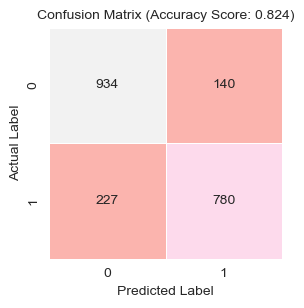

In [263]:
#Confusion Matrix

knn_conf_matrix = confusion_matrix(y_test1, y_pred)

fig, ax = plt.subplots(figsize=(3, 3))
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', linewidths=.5, cmap='Pastel1', cbar=False, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_title(f'Confusion Matrix (Accuracy Score: {accuracy_score(y_test1, y_pred):.3f})', fontsize=10)
plt.show()

In [265]:
# Classification report
KNN_Classification_Report = classification_report(y_test1,y_pred)
print(KNN_Classification_Report)

              precision    recall  f1-score   support

           0       0.80      0.87      0.84      1074
           1       0.85      0.77      0.81      1007

    accuracy                           0.82      2081
   macro avg       0.83      0.82      0.82      2081
weighted avg       0.83      0.82      0.82      2081



We can see from the confusion matrix that our KNN classifier has an accuracy of approx 82%.

### Model 2 : MLP (Multilayer Perceptron)

In [266]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(eyes_array['ImageFile'], eyes_array['Class'], test_size = 0.2, random_state = 42)
X_val2, X_test2,y_val2, y_test2 = train_test_split(X_val2, y_val2, test_size = 0.5, random_state = 42)

x_train2, x_val2, x_test2, y_train2, y_val2, y_test2 = clean_data([X_train2, X_val2, X_test2, y_train2, y_val2, y_test2])

In [231]:
# Model architechture
MLP = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1024, activation=tf.nn.leaky_relu), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu), 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

In [267]:
num_male = len(y_train2[y_train2 > 0])
num_female = len(y_train2) - num_male
total_samples = len(y_train2)
weight_male = total_samples / (2 * num_male) 
weight_female = total_samples / (2 * num_female)
class_weights = {0: weight_female, 1: weight_male}
print(class_weights)

# Optimizer
adam_optim = tf.keras.optimizers.Adam()

{0: 1.0081153100775193, 1: 0.9920143027413587}


In [268]:
MLP.compile(
    optimizer=adam_optim,
    loss='binary_crossentropy',
    metrics=[
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
    ]
)

In [269]:
# Data preprocessing
scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train2)

# Model training
history = MLP.fit(
    x=x_train_std,
    y=y_train2,
    class_weight=class_weights,
    batch_size=64,
    validation_data=(x_val2, y_val2),
    epochs=20,
    verbose=1
)

Epoch 1/20
131/131 [==============================] - 51s 213ms/step - loss: 5.9380 - tp: 2987.0000 - fp: 1253.0000 - tn: 2875.0000 - fn: 1208.0000 - accuracy: 0.7043 - precision: 0.7045 - recall: 0.7120 - auc: 0.7300 - val_loss: 98.0949 - val_tp: 457.0000 - val_fp: 155.0000 - val_tn: 374.0000 - val_fn: 54.0000 - val_accuracy: 0.7990 - val_precision: 0.7467 - val_recall: 0.8943 - val_auc: 0.8014
Epoch 2/20
131/131 [==============================] - 26s 195ms/step - loss: 2.7217 - tp: 3271.0000 - fp: 951.0000 - tn: 3177.0000 - fn: 924.0000 - accuracy: 0.7747 - precision: 0.7748 - recall: 0.7797 - auc: 0.8140 - val_loss: 49.5248 - val_tp: 360.0000 - val_fp: 64.0000 - val_tn: 465.0000 - val_fn: 151.0000 - val_accuracy: 0.7933 - val_precision: 0.8491 - val_recall: 0.7045 - val_auc: 0.7963
Epoch 3/20
131/131 [==============================] - 23s 175ms/step - loss: 1.3403 - tp: 3424.0000 - fp: 824.0000 - tn: 3304.0000 - fn: 771.0000 - accuracy: 0.8084 - precision: 0.8060 - recall: 0.8162 - 

In [273]:
# Evaluate model
x_test_std = scaler.fit_transform(x_test2)
score = MLP.evaluate(x_test_std, y_test2, verbose=0)

In [274]:
# Generate predictions on standardized test data
y_pred_MLP= MLP.predict(x_test_std)

# Convert predicted probabilities to binary predictions
y_pred_MLP = np.where(y_pred_MLP > 0.5, 1, 0)

# Print the first 10 predictions for demonstration purposes
print('First 10 binary predictions:')
print(y_pred_MLP[:10])


33/33 [==============================] - 1s 18ms/step
First 10 binary predictions:
[[0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]]


In [275]:
# Classification report
ClassificationReport_MLP = classification_report(y_test2,y_pred_MLP)
print(ClassificationReport_MLP)

              precision    recall  f1-score   support

           0       0.96      0.75      0.84       545
           1       0.78      0.96      0.86       496

    accuracy                           0.85      1041
   macro avg       0.87      0.86      0.85      1041
weighted avg       0.87      0.85      0.85      1041



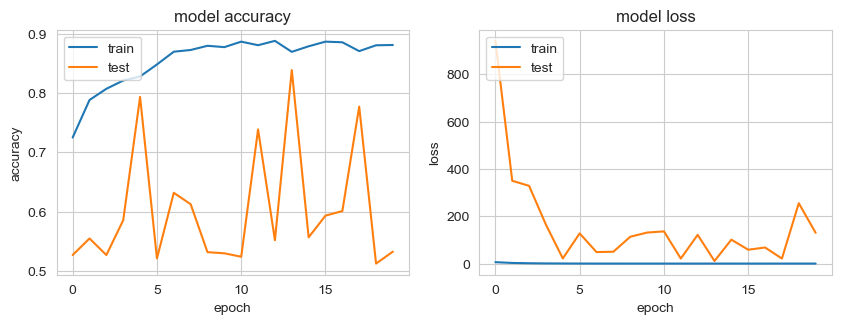

In [276]:
# summarize history for accuracy
plt.figure(figsize=(10,7))

plt.subplot(2,2,1)
plt.plot(mlp_history.history['accuracy'])
plt.plot(mlp_history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('model accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2,2,2)
plt.plot(mlp_history.history['loss'])
plt.plot(mlp_history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model 3 : CNN

In [277]:
# Helper function
def convert_to_tensor_list(_list):
    LIST = []
    for i in range(len(_list)):
        LIST.append(tf.convert_to_tensor(_list[i]))
    return LIST

In [278]:
# Helper function
# Function to reset the index and reshape the array 
def cleaned_2(X):
    for i in range(len(X)):
        X[i] = np.stack(X[i].reset_index(drop=True))
    return X

In [279]:
# Convert image path to array of image using cv2
size = (64,64)
eyes2 = eyes.copy()

for i in range(len(eyes)):
    image=cv2.imread(eyes['ImageFile'][i])
    image=cv2.resize(image,size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    eyes2['ImageFile'][i] = image
    
# Convert labels to numeric values

eyes2['Class'] = np.asarray(Encoder.fit_transform(eyes2["Class"]))

display(eyes2.head())

,ImageFile,Class
0,"[[[173, 132, 112], [169, 128, 108], [168, 127,...",0
1,"[[[230, 230, 228], [235, 234, 230], [229, 223,...",0
2,"[[[153, 153, 153], [153, 153, 153], [153, 153,...",1
3,"[[[234, 176, 152], [229, 171, 147], [223, 166,...",1
4,"[[[255, 179, 107], [255, 177, 105], [255, 173,...",1


In [280]:
x_train3, x_val3, y_train3, y_val3 = train_test_split(eyes2['ImageFile'], eyes2['Class'], test_size = 0.2, random_state = 42)
x_val3, x_test3, y_val3, y_test3 = train_test_split(x_val3, y_val3, test_size = 0.5, random_state = 42)

x_train3, x_val3, x_test3, y_train3, y_val3, y_test3 = cleaned_2([x_train3, x_val3, x_test3, y_train3, y_val3, y_test3])
x_train3, x_val3, x_test3, y_train3, y_val3, y_test3 = to_tensor([x_train3, x_val3, x_test3, y_train3, y_val3, y_test3])

In [281]:
CNN_model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1,activation='sigmoid')  
])

In [287]:
# Compile the CNN model
optimizer = 'adam'
loss = 'BinaryCrossentropy'
metrics = ['accuracy']

CNN_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [290]:
# Train the CNN model
cnn_history = CNN_model.fit(
    x=x_train3,
    y=y_train3,
    validation_data=(x_val3, y_val3),
    epochs=20
)

Epoch 1/20
261/261 [==============================] - 58s 221ms/step - loss: 0.1959 - accuracy: 0.9268 - val_loss: 0.2515 - val_accuracy: 0.9000
Epoch 2/20
261/261 [==============================] - 58s 224ms/step - loss: 0.1909 - accuracy: 0.9309 - val_loss: 0.2352 - val_accuracy: 0.9077
Epoch 3/20
261/261 [==============================] - 57s 219ms/step - loss: 0.1717 - accuracy: 0.9363 - val_loss: 0.2450 - val_accuracy: 0.9000
Epoch 4/20
261/261 [==============================] - 57s 219ms/step - loss: 0.1618 - accuracy: 0.9374 - val_loss: 0.2417 - val_accuracy: 0.9212
Epoch 5/20
261/261 [==============================] - 58s 223ms/step - loss: 0.1412 - accuracy: 0.9486 - val_loss: 0.5032 - val_accuracy: 0.8365
Epoch 6/20
261/261 [==============================] - 58s 221ms/step - loss: 0.1270 - accuracy: 0.9528 - val_loss: 0.2083 - val_accuracy: 0.9183
Epoch 7/20
261/261 [==============================] - 58s 222ms/step - loss: 0.1312 - accuracy: 0.9513 - val_loss: 0.2386 - val_ac

In [291]:
# Generate predictions on test data
y_pred_CNN = CNN_model.predict(x_test3)

# Convert predicted probabilities to binary predictions
y_pred_CNN = np.round(y_pred_CNN)

33/33 [==============================] - 2s 36ms/step


In [292]:
# Classification report
CNN_Classification_Report = classification_report(y_test3, y_pred_CNN)
print(CNN_Classification_Report)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       545
           1       0.93      0.93      0.93       496

    accuracy                           0.94      1041
   macro avg       0.94      0.94      0.94      1041
weighted avg       0.94      0.94      0.94      1041



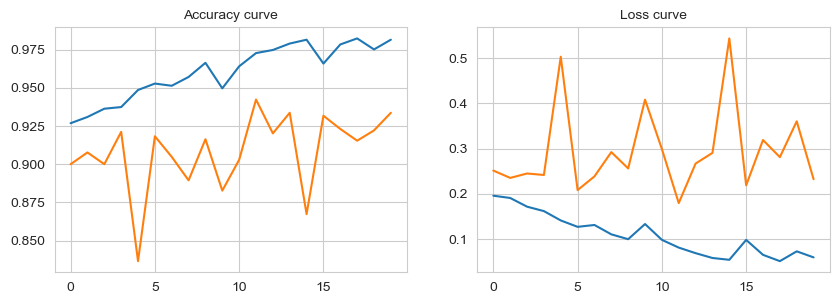

In [293]:
plt.figure(figsize=(10,7))

plt.subplot(2,2,1)
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Accuracy curve',fontdict={'size':10})

plt.subplot(2,2,2)
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Loss curve',fontdict={'size':10})
plt.show()

In [296]:
results = pd.DataFrame({'Model': ['KNN', 'MLP', 'CNN'], 'Accuracy': [accuracy_score(y_test1,y_pred), accuracy_score(y_test2, y_pred_MLP), accuracy_score(y_test3, y_pred_CNN)]})
results

,Model,Accuracy
0,KNN,0.823642
1,MLP,0.852065
2,CNN,0.936599


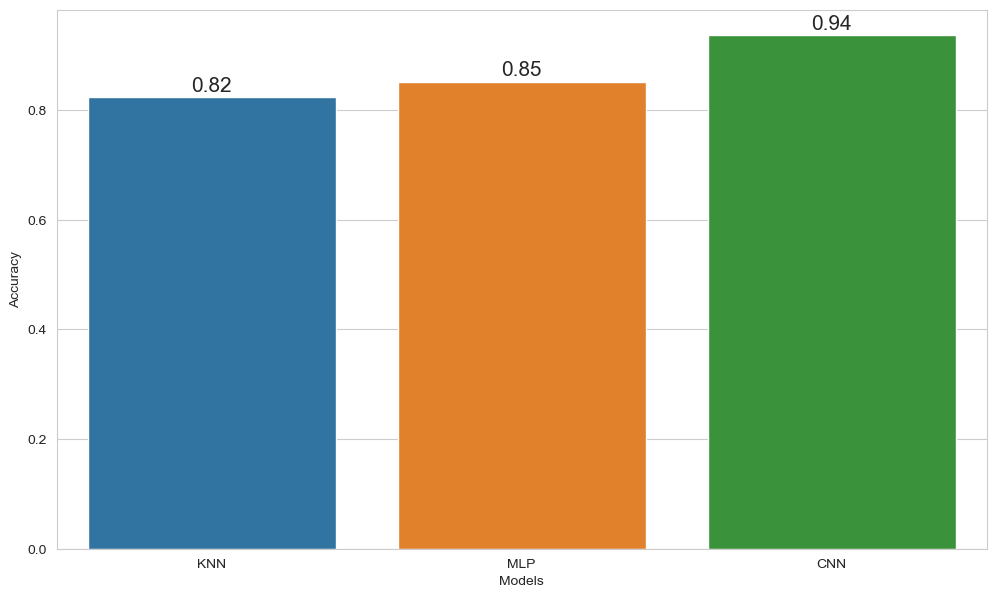

In [297]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Accuracy', data=results)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.xticks;

### Observations and Findings

- As we can see from the classification report and accuracy comparison, the CNN model has the highest accuracy among all three models. The CNN model was able to correctly classify 94% of the eye images as either male or female. This is a significant improvement over the benchmark model and the MLP model. The benchmark model (KNN) achieved an accuracy of 82%, while the MLP model achieved an accuracy of 85%. Therefore, we can conclude that the CNN model is the best model for this task.

- #### Conclusion


- In conclusion, we have successfully implemented three classification models to determine the gender of an individual based on their eye image. We used EDA and data preprocessing techniques to prepare the data for training the models. We implemented a benchmark model (KNN), an MLP model, and a CNN model. We also used various techniques such as regularization, dropout, and data augmentation to improve the performance of the MLP and CNN models. Finally, we evaluated the performance of all three models and concluded that the CNN model is the best model for this task.